In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.cosmology import Planck18
import sys
sys.path.append('/idia/projects/mightee/zchen/hiimtool/src/')
from hiimtool.hiimvis import  Specs,inversemab,vis_power_3d,BrightnessTempPS
from hiimtool.util import p2dim,slicer_vectorized,bin_3d_to_1d,bin_3d_to_cy,calcov,getvis
#from katbeam import JimBeam
import glob
from scipy.signal import blackmanharris
from astropy import constants,units
import torch
import datetime

The ``freq_arr`` is simply read from the measurementset metadata, here I just saved it to cut some slack.

In [2]:
# this is the frequency channels for the z=0.32 bin
freq_arr = np.load('/idia/projects/mightee/zchen/freqarr.npy')

The ``Specs`` object stores some basic quantity that can be useful. The FWHM stuff is a relic of an older version, simply ignore

In [3]:
sp = Specs(cosmo = Planck18,
           freq_start_hz = freq_arr[0],
           num_channels = len(freq_arr),
           deltav_ch = np.diff(freq_arr).mean(),
           FWHM_ref = 83.94201153142113/60*np.pi/180,
           FWHM_freq_ref = 1050e6,)

fill=True

umodeedges = np.linspace(-6000,6000,201)-30 # in lambda
ucen = (umodeedges[1:]+umodeedges[:-1])/2


Reading the data is different depending on whether inpainting is done. Either way, u-v grids are only saved when all frequency channels for that grid are sampled by both even and odd scan.

In [4]:
vis_dir = '/idia/projects/mightee/DEEP2_data/gridded_vis/'

In [5]:
vis_file = [vis_dir+'vissum_even_220_fill_True_I.npy',
            vis_dir+'vissum_odd_220_fill_True_I.npy',
            vis_dir+'count_even_220_fill_True_I.npy',
            vis_dir+'count_odd_220_fill_True_I.npy'
           ]

In [6]:
visi_even,visi_odd,counti_even,counti_odd,umode_i,uarr_i,varr_i = getvis(vis_file,fill,umodeedges)

/idia/projects/mightee/zchen/hiimtool/src/hiimtool/util.py:278: RuntimeWarning: invalid value encountered in divide
  visavg_even = np.nan_to_num(visavg_even/counttot_even)
/idia/projects/mightee/zchen/hiimtool/src/hiimtool/util.py:279: RuntimeWarning: invalid value encountered in divide
  visavg_odd = np.nan_to_num(visavg_odd/counttot_odd)


To perform the delay transform, define a frequency taper:

In [16]:
window = blackmanharris(sp.num_channels)
# cross-power
px3d = vis_power_3d(sp,visi_even,vis_2 = visi_odd,window=window)
# auto-power
podd3d = vis_power_3d(sp,visi_odd,window=window)
peven3d = vis_power_3d(sp,visi_even,window=window)


Now we can visualise the power spectrum. The 3-d power has dimensions of (num_delay,num_grids)

In [35]:
px3d_f.shape

(220, 39406)

Along the delay axis, the $k_\parallel$ can be read from the ``Specs`` since it only depends on your frequency bins

In [36]:
kpara = 2*np.pi*sp.eta_arr()/sp.Y_0()

The $k_\perp$ depends on the u-v grids you use:

In [37]:
kperp_i = 2*np.pi*umode_i/sp.X_0()

Now we can bin the 3-D power to cylindrical. For example:

In [38]:
# the cylindrical k_perp bin for visualization
uperpedges = np.linspace(0,6000,61)

# the k_para bin
kparaarr = kpara[:111]
kparaarr[-1] = kpara[110]*-1

The ``bin_3d_to_cy`` function only needs to know what $|u|$ bin you are putting in. The $k_\parallel$ direction has no binning. The ``p2dim`` function simply averages the negative $k_\parallel$ to positive ones

In [39]:
poddcy = bin_3d_to_cy(podd3d,umode_i,uperpedges)
poddarr = p2dim(poddcy.T)
pevency = bin_3d_to_cy(podd3d,umode_i,uperpedges)
pevenarr = p2dim(pevency.T)
pxcy = bin_3d_to_cy(px3d,umode_i,uperpedges)
pxarr = p2dim(pxcy.T)

The $k_\perp$ corresponding to ``uperpedges`` is:

In [40]:
kperpedges = 2*np.pi*uperpedges/sp.X_0()

The conversion between $\rm Jy^2 Hz^2$ is:

In [41]:
fov = 0.0003114669668997865
renorm = 1/fov/(sp.deltav_ch*sp.num_channels)**2*sp.X_0()**2*(sp.Y_0()*sp.deltav_ch*sp.num_channels)*(sp.lambda_0()**2*units.m**2/2/constants.k_B)**2*units.Jy**2
renorm = renorm.to('K^2').value

In [42]:
pxarr.shape

(60, 111)

Text(0.5, 1.0, 'even auto-power')

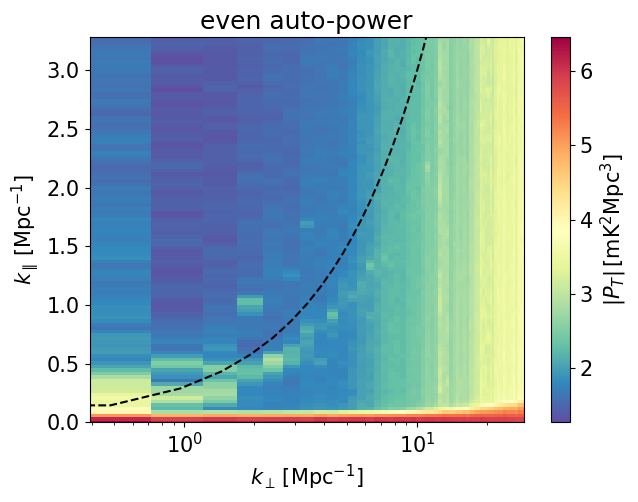

In [44]:
plt.rcParams.update({'font.size':15})
plt.figure(dpi=100,figsize=(7,5))
plt.pcolormesh(kperpedges[:-1],kparaarr[:111],(np.log10((pevenarr)*renorm*1e6)).T,
              cmap='Spectral_r',)
plt.ylim(0,np.abs(kpara).max())
plt.plot(kperpedges[:-1],kperpedges[:-1]*0.3,ls='--',color='black')

plt.xscale('log')
cbar=plt.colorbar()
cbar.set_label(r'$|P_T|\,{\rm [mK^2Mpc^3]}$')
plt.xlabel(r'$k_\perp\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k_\parallel\,[{\rm Mpc^{-1}}]$')
plt.title('even auto-power')

/tmp/ipykernel_403059/1955764593.py:3: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(kperpedges[:-1],kparaarr[:111],(np.log10((pxarr)*renorm*1e6)).T,


Text(0.5, 1.0, 'evenxodd')

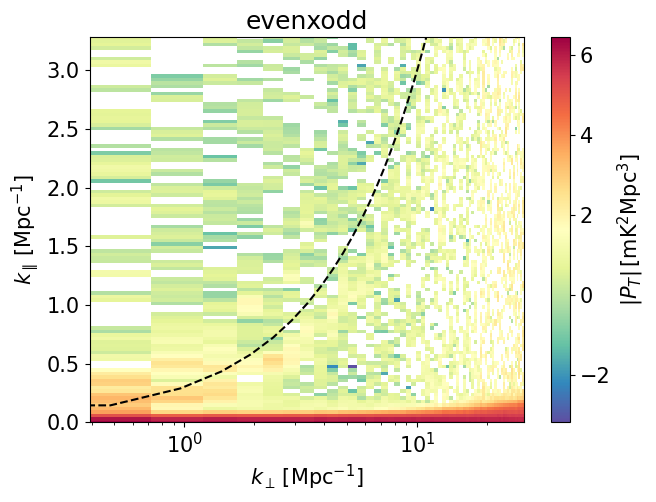

In [45]:
plt.rcParams.update({'font.size':15})
plt.figure(dpi=100,figsize=(7,5))
plt.pcolormesh(kperpedges[:-1],kparaarr[:111],(np.log10((pxarr)*renorm*1e6)).T,
              cmap='Spectral_r',)
plt.ylim(0,np.abs(kpara).max())
plt.plot(kperpedges[:-1],kperpedges[:-1]*0.3,ls='--',color='black')

plt.xscale('log')
cbar=plt.colorbar()
cbar.set_label(r'$|P_T|\,{\rm [mK^2Mpc^3]}$')
plt.xlabel(r'$k_\perp\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k_\parallel\,[{\rm Mpc^{-1}}]$')
plt.title('evenxodd')

We can bin the 3-D power into 1-D as well. For each 3-D power, the 1-D $k$ can be calculated as:

In [46]:
kmode_i = np.sqrt(kperp_i[None,:]**2+kpara[:,None]**2)

Suppose we only want k-points at $k_\parallel>0.3 k_\perp$:

In [47]:
horizon = (np.abs(kpara)[:,None]>=0.3*np.abs(kperp_i)[None,:])

In [49]:
kmin,kmax = (kmode_i[horizon].min(),kmode_i[horizon].max())
k1dedges = np.logspace(np.log10(kmin*0.9999),
                       np.log10(kmax*1.0001),8)

In [53]:
px1d,px1derr,_,_ = bin_3d_to_1d(px3d,kmode_i,k1dedges,weights=horizon,error=True)
peven1d,peven1derr,_,_ = bin_3d_to_1d(peven3d,kmode_i,k1dedges,weights=horizon,error=True)
keff,_,_,_ = bin_3d_to_1d(kmode_i,kmode_i,k1dedges,weights=horizon,error=True)

In [52]:
xerr1 = keff-k1dedges[:-1]
xerr2 = k1dedges[1:]-keff

Text(0.5, 1.0, 'cross power')

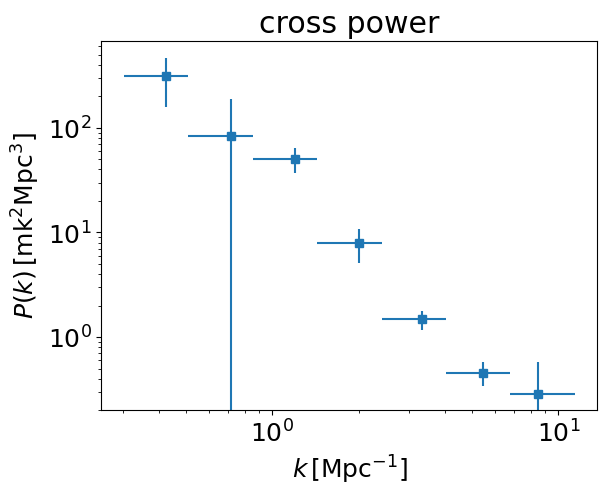

In [55]:
plt.rcParams.update({'font.size':18})
plt.figure(dpi=100)
plt.errorbar(keff,px1d*renorm*1e6,yerr=px1derr*renorm*1e6,xerr=[xerr1,xerr2],fmt='s',label='signal',)


plt.xscale('log')
plt.yscale('log')
#plt.ylim(5e-2,1e2)
plt.xlabel(r'$k \,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$P(k)\, [{\rm mk^2 Mpc^3}]$')
plt.title(r'cross power')
#plt.text(0.11,95,r'$\mathbf{a}$',fontsize=25)

Text(0.5, 1.0, 'even autopower')

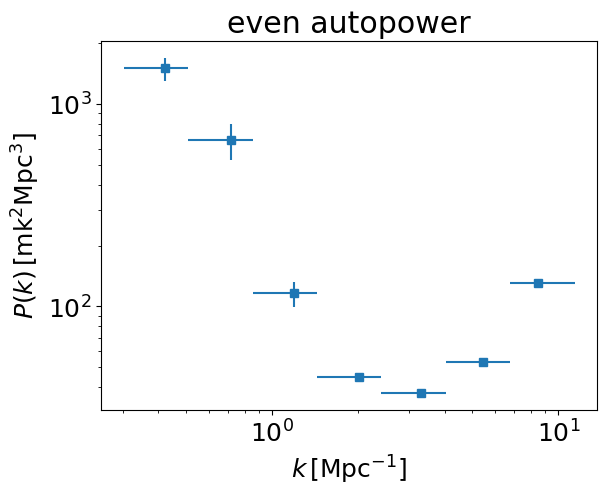

In [56]:
plt.rcParams.update({'font.size':18})
plt.figure(dpi=100)
plt.errorbar(keff,peven1d*renorm*1e6,yerr=peven1derr*renorm*1e6,xerr=[xerr1,xerr2],fmt='s',label='signal',)


plt.xscale('log')
plt.yscale('log')
#plt.ylim(5e-2,1e2)
plt.xlabel(r'$k \,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$P(k)\, [{\rm mk^2 Mpc^3}]$')
plt.title(r'even autopower')

Note that this is just uniform weighting with no thermal noise 5-sigma cut